<a href="https://colab.research.google.com/github/ayla011/diabetes_prediction_model/blob/main/Who's_at_Risk_of_Diabetes%3F_(with_Prediction_Model).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = '100000-diabetes-clinical-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5420190%2F8998172%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240818%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240818T033105Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D4fc4f8aceec12b96fd5099c7e7839789e3cf5e3add1eee533fb7e41c6b6b8ffe1eb2ded8450a64afb17788ce6700744a0258429bd4624c3e4ad12b748a97a92e2a09e763dd33009179a34bcd95f0e593a4bb8d7140ea0e45c78512d17f7db0031358d6583d62986386f86d691f7648f267118e85373c35eaee64189b4497049d6a7bfaf8d8a70b2da98c4d1d37d405c814c1a834b6d8e35b528017c3915adfaaf4a1c629b764b08fb32fda6dc6f36447c30d9884e7f24c6c58c1de0ab29a0bf304282c9ae420f727cf07607a38cf4e91851408e4f2e15bc602de3468a8981ab13abc4003fc03ba78e29a86cdfd6cc4f81bc76a37bab9dbe87d18ec02c114c2e9'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 917848 bytes downloaded
Downloaded and uncompressed: 100000-diabetes-clinical-dataset
Data source import complete.


# Importing Modules

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, mannwhitneyu, chi2_contingency, chi2
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Inspecting the Dataset

In [3]:
df = pd.read_csv("/kaggle/input/100000-diabetes-clinical-dataset/diabetes_dataset.csv")

In [4]:
df.head()

,year,gender,age,location,race:AfricanAmerican,race:Asian,race:Caucasian,race:Hispanic,race:Other,hypertension,heart_disease,smoking_history,bmi,hbA1c_level,blood_glucose_level,diabetes
0,2020,Female,32.0,Alabama,0,0,0,0,1,0,0,never,27.32,5.0,100,0
1,2015,Female,29.0,Alabama,0,1,0,0,0,0,0,never,19.95,5.0,90,0
2,2015,Male,18.0,Alabama,0,0,0,0,1,0,0,never,23.76,4.8,160,0
3,2015,Male,41.0,Alabama,0,0,1,0,0,0,0,never,27.32,4.0,159,0
4,2016,Female,52.0,Alabama,1,0,0,0,0,0,0,never,23.75,6.5,90,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   year                  100000 non-null  int64  
 1   gender                100000 non-null  object 
 2   age                   100000 non-null  float64
 3   location              100000 non-null  object 
 4   race:AfricanAmerican  100000 non-null  int64  
 5   race:Asian            100000 non-null  int64  
 6   race:Caucasian        100000 non-null  int64  
 7   race:Hispanic         100000 non-null  int64  
 8   race:Other            100000 non-null  int64  
 9   hypertension          100000 non-null  int64  
 10  heart_disease         100000 non-null  int64  
 11  smoking_history       100000 non-null  object 
 12  bmi                   100000 non-null  float64
 13  hbA1c_level           100000 non-null  float64
 14  blood_glucose_level   100000 non-null  int64  
 15  d

In [6]:
df.describe()

,year,age,race:AfricanAmerican,race:Asian,race:Caucasian,race:Hispanic,race:Other,hypertension,heart_disease,bmi,hbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,2018.360820,41.885856,0.202230,0.200150,0.198760,0.19888,0.199980,0.07485,0.039420,27.320767,5.527507,138.058060,0.085000
std,1.345239,22.516840,0.401665,0.400114,0.399069,0.39916,0.399987,0.26315,0.194593,6.636783,1.070672,40.708136,0.278883
min,2015.000000,0.080000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,2019.000000,24.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,2019.000000,43.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,2019.000000,60.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,29.580000,6.200000,159.000000,0.000000
max,2022.000000,80.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.00000,1.000000,95.690000,9.000000,300.000000,1.000000


# Balancing and Cleaning the Dataset

<ipython-input-7-c091020b8017>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  d.set_xticklabels(["Non-Diabetic", "Diabetic"])


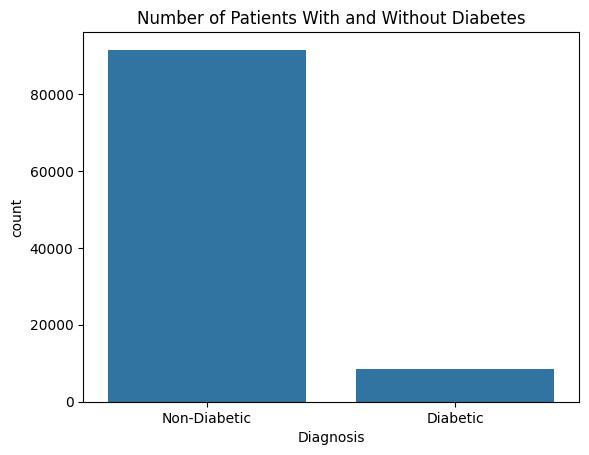

In [7]:
d = sns.countplot(data = df, x = "diabetes")
d.set_title("Number of Patients With and Without Diabetes")
d.set_xlabel("Diagnosis")
d.set_xticklabels(["Non-Diabetic", "Diabetic"])
plt.show()

In [8]:
df_race = df[["race:AfricanAmerican", "race:Asian", "race:Caucasian", "race:Hispanic", "race:Other"]]
by_race = pd.from_dummies(df_race)
df2 = df.drop(columns = ["race:AfricanAmerican", "race:Asian", "race:Caucasian", "race:Hispanic", "race:Other"])
df2.insert(2, "race", by_race)
df2["race"] = df2["race"].str.replace("race:", "")
df2["race"] = df2["race"].str.replace("AfricanAmerican", "African-American")

In [9]:
bins = [0, 18, 25, 35, 45, 55, 65, np.inf]
age_order = ["0-18", "18-24", "25-34", "35-44", "45-54", "55-64", "65+"]
df2.insert(3, "age_cat", pd.cut(df2["age"], bins, labels = age_order))

In [10]:
bins = [0, 18.5, 25, 30, 35, 40, np.inf]
bmi_order = ["Underweight", "Normal", "Overweight", "Moderately Obese", "Severely Obese", "Morbidly Obese"]
df2.insert(9, "bmi_cat", pd.cut(df2["bmi"], bins, labels = bmi_order))

In [11]:
df2["smoking_history"] = df2["smoking_history"].str.title()
df2 = df2[df2["smoking_history"] != "No Info"]

In [12]:
columns = ['gender', 'race', 'age_cat', 'location', 'hypertension','heart_disease', 'smoking_history', 'bmi_cat', 'diabetes']

for col in columns:
    if col in ['gender', 'race', 'age_cat', 'location', 'smoking_history', 'bmi_cat']:
        df2[col] = df2[col].astype("category")
    else:
        df2[col] = df2[col].astype("bool")

<ipython-input-12-f37700259102>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[col] = df2[col].astype("category")
<ipython-input-12-f37700259102>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2[col] = df2[col].astype("category")


In [13]:
columns = list(df2.columns)
new_name = [col.title() for col in columns]

for c, n in zip(columns, new_name):
    df2 = df2.rename(columns = {c:n})

df2 = df2.rename(columns = {"Age_Cat":"Age Group",
                            "Heart_Disease":"Heart Disease",
                            "Smoking_History":"Smoking History",
                            "Bmi_Cat":"BMI Category",
                            "Bmi":"BMI",
                            "Hba1C_Level":"HbA1C Level",
                            "Blood_Glucose_Level":"Blood Glucose Level"
                           }
                )
df2.head()

,Year,Gender,Race,Age Group,Age,Location,Hypertension,Heart Disease,Smoking History,BMI Category,BMI,HbA1C Level,Blood Glucose Level,Diabetes
0,2020,Female,Other,25-34,32.0,Alabama,False,False,Never,Overweight,27.32,5.0,100,False
1,2015,Female,Asian,25-34,29.0,Alabama,False,False,Never,Normal,19.95,5.0,90,False
2,2015,Male,Other,0-18,18.0,Alabama,False,False,Never,Normal,23.76,4.8,160,False
3,2015,Male,Caucasian,35-44,41.0,Alabama,False,False,Never,Overweight,27.32,4.0,159,False
4,2016,Female,African-American,45-54,52.0,Alabama,False,False,Never,Normal,23.75,6.5,90,False


<ipython-input-14-c6ebf80975c2>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  d.set_xticklabels(["Non-Diabetic", "Diabetic"])


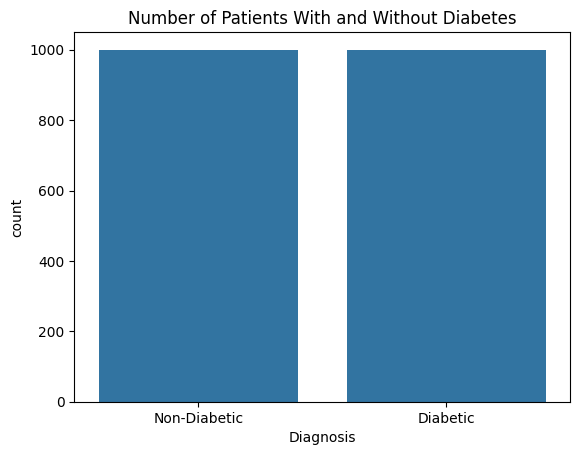

In [14]:
diabetes_yes = df2[df2["Diabetes"] == True].sample(n = 1000, ignore_index = True)
diabetes_no = df2[df2["Diabetes"] == False].sample(n = 1000, ignore_index = True)

df2 = pd.concat([diabetes_yes, diabetes_no], axis = 0)

d = sns.countplot(data = df2, x = "Diabetes")
d.set_title("Number of Patients With and Without Diabetes")
d.set_xlabel("Diagnosis")
d.set_xticklabels(["Non-Diabetic", "Diabetic"])
plt.show()

In [15]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Year                 2000 non-null   int64   
 1   Gender               2000 non-null   category
 2   Race                 2000 non-null   category
 3   Age Group            2000 non-null   category
 4   Age                  2000 non-null   float64 
 5   Location             2000 non-null   category
 6   Hypertension         2000 non-null   bool    
 7   Heart Disease        2000 non-null   bool    
 8   Smoking History      2000 non-null   category
 9   BMI Category         2000 non-null   category
 10  BMI                  2000 non-null   float64 
 11  HbA1C Level          2000 non-null   float64 
 12  Blood Glucose Level  2000 non-null   int64   
 13  Diabetes             2000 non-null   bool    
dtypes: bool(3), category(6), float64(3), int64(2)
memory usage: 114.9 KB


# Exploratory Data Analysis

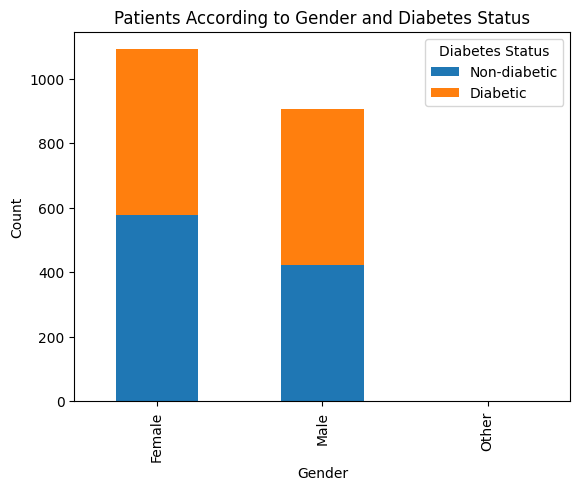

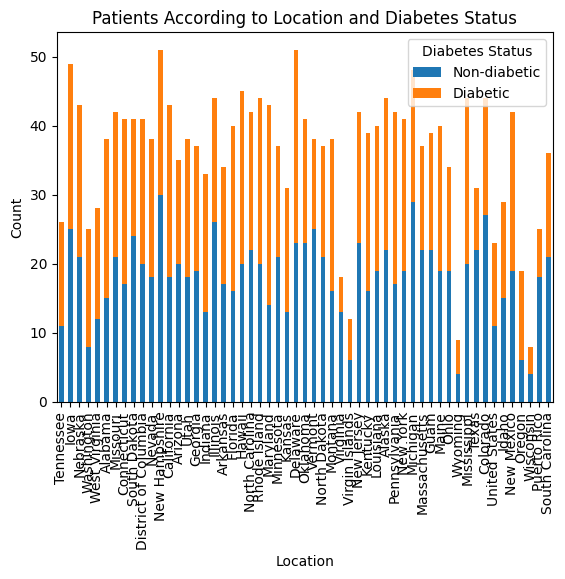

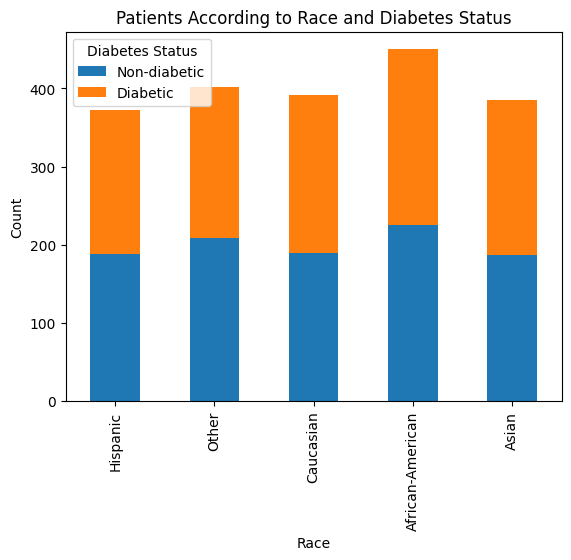

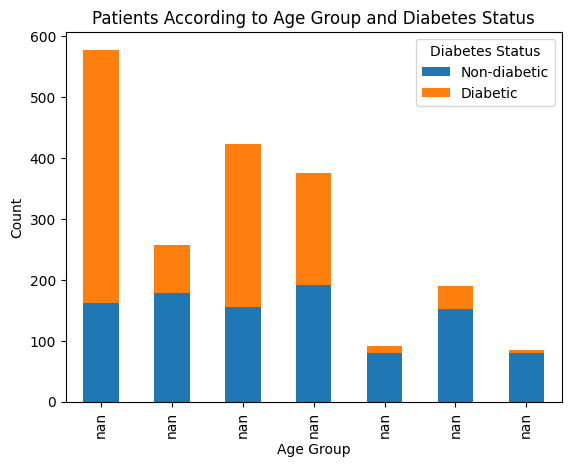

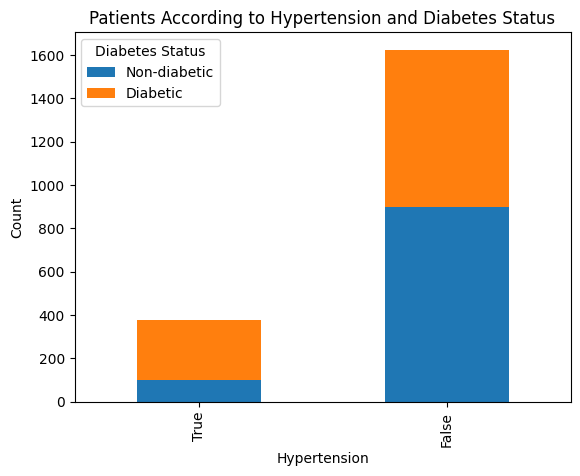

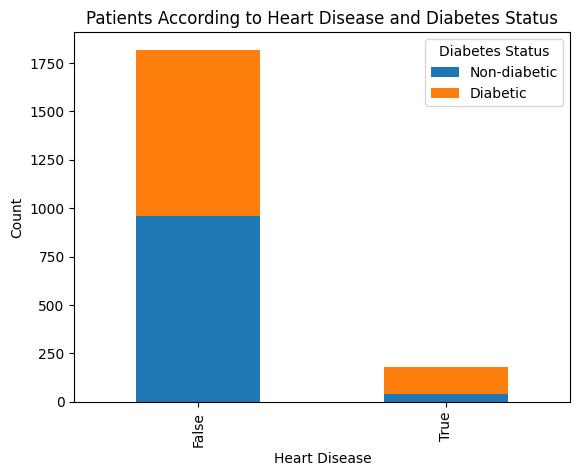

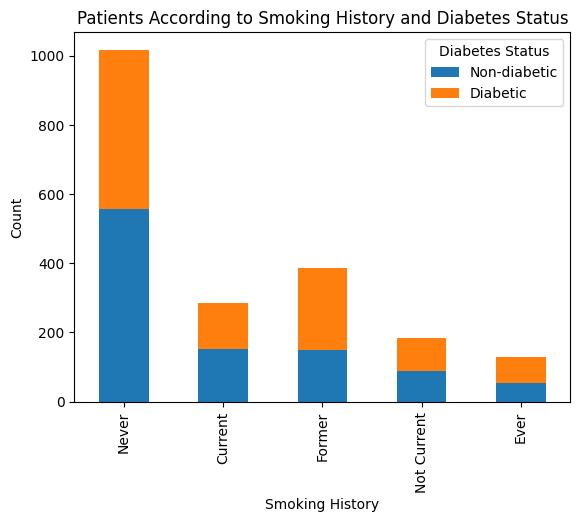

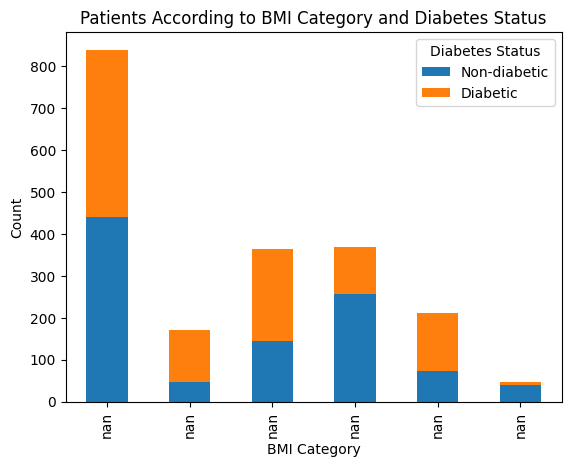

In [16]:
cat_columns = ["Gender",
               "Location",
               "Race",
               "Age Group",
               "Hypertension",
               "Heart Disease",
               "Smoking History",
               "BMI Category"]

for col in cat_columns:

    categories = list(df2[col].unique())

    non_diabetic_counts = []
    diabetic_counts = []

    for cat in categories:

        non_diabetic = df2[(df2[col] == cat) & (df2["Diabetes"] == False)].shape[0]
        diabetic = df2[(df2[col] == cat) & (df2["Diabetes"] == True)].shape[0]

        non_diabetic_counts.append(non_diabetic)
        diabetic_counts.append(diabetic)

    d = pd.DataFrame({col: categories, "Non-diabetic": non_diabetic_counts, "Diabetic": diabetic_counts})

    if col in ["Age Group", "BMI Category"]:
        order = [age_order, bmi_order]
        for o in order:
            d[col] = pd.Categorical(d[col], categories = o, ordered=True)
        d_sorted = d.sort_values(col)
        d_sorted.plot(x = col, kind = "bar", stacked = True)

    else:
        d.plot(x = col, kind = "bar", stacked = True)

    plt.title(f"Patients According to {col} and Diabetes Status")
    plt.xlabel(f"{col}")
    plt.ylabel("Count")
    plt.legend(title = "Diabetes Status")
    plt.show()



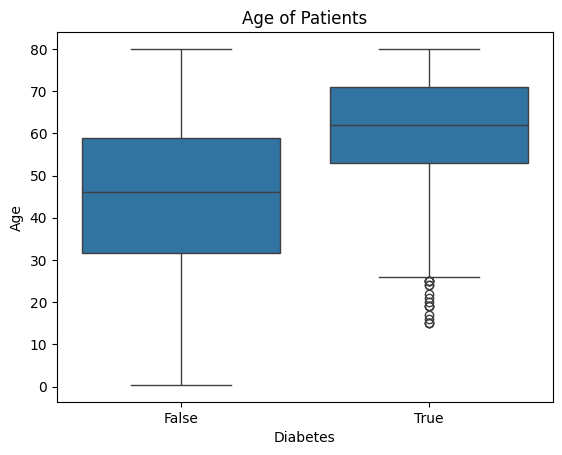

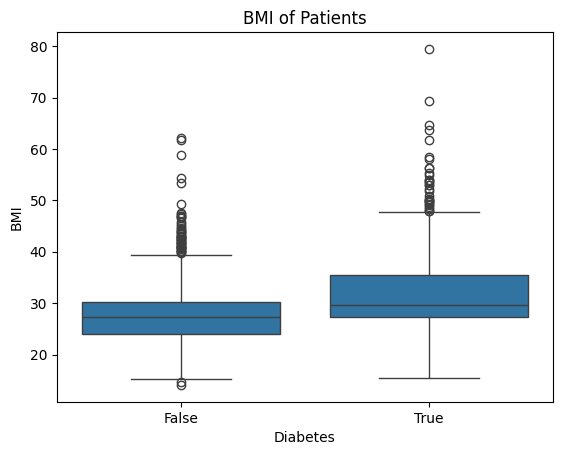

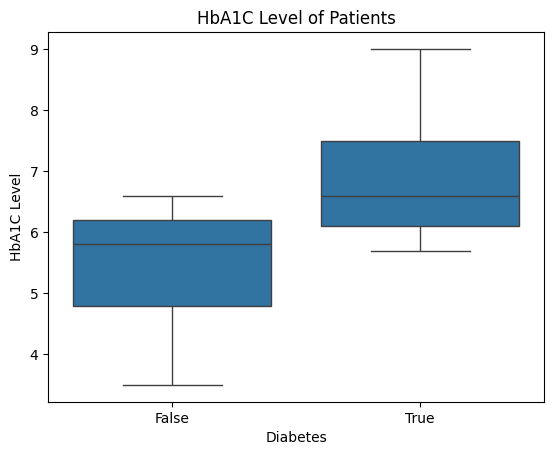

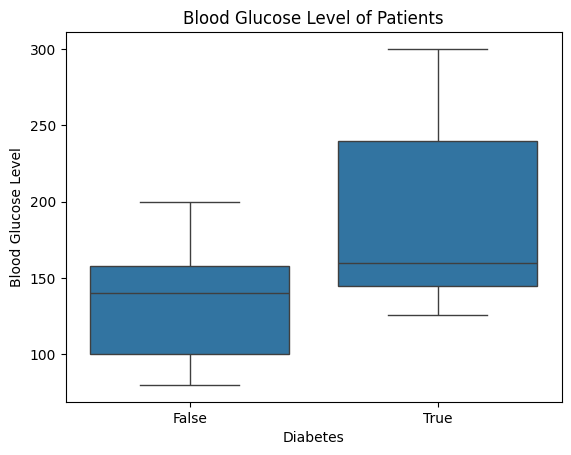

In [17]:
num_columns = ["Age", "BMI", "HbA1C Level", "Blood Glucose Level"]

for col in num_columns:
    n = sns.boxplot(data = df2, x = "Diabetes", y = col)
    n.set_title(f"{col} of Patients")
    plt.show()

# Correlation Matrix

In [18]:
df_encoded = df2.drop(columns = "Age Group")
le = LabelEncoder()

df_encoded["Gender"] = le.fit_transform(df_encoded["Gender"])
df_encoded["Location"] = le.fit_transform(df_encoded["Location"])
df_encoded["Race"] = le.fit_transform(df_encoded["Race"])
df_encoded["BMI Category"] = le.fit_transform(df_encoded["BMI Category"])
df_encoded["Smoking History"] = le.fit_transform(df_encoded["Smoking History"])
df_encoded

,Year,Gender,Race,Age,Location,Hypertension,Heart Disease,Smoking History,BMI Category,BMI,HbA1C Level,Blood Glucose Level,Diabetes
0,2019,0,3,66.0,44,True,False,3,3,27.01,6.8,280,True
1,2019,1,4,38.0,16,False,False,0,3,27.32,6.1,240,True
2,2016,0,2,57.0,28,False,False,3,3,28.90,6.2,159,True
3,2016,0,0,65.0,51,False,True,0,3,26.09,5.7,300,True
4,2019,0,4,51.0,52,False,False,3,3,25.24,6.6,240,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2019,0,0,80.0,12,True,True,3,3,29.40,6.0,80,False
996,2019,1,1,49.0,12,False,False,2,3,26.38,5.0,155,False
997,2019,0,2,41.0,22,True,False,3,1,44.59,4.0,145,False
998,2019,0,2,20.0,39,False,False,3,2,22.28,3.5,140,False


In [19]:
corr_mat = df_encoded.corr()
corr_mat

,Year,Gender,Race,Age,Location,Hypertension,Heart Disease,Smoking History,BMI Category,BMI,HbA1C Level,Blood Glucose Level,Diabetes
Year,1.000000,0.010211,-0.014803,0.004849,-0.049408,-0.040689,0.044004,-0.018540,-0.024943,0.008746,-0.039012,0.000462,-0.011935
Gender,0.010211,1.000000,-0.000281,0.060510,-0.015247,0.033136,0.108669,-0.097180,-0.027933,0.033509,0.012602,0.032495,0.062127
Race,-0.014803,-0.000281,1.000000,-0.004985,0.037360,0.024397,-0.010948,0.000162,0.000093,0.010503,-0.024220,0.001876,-0.014909
Age,0.004849,0.060510,-0.004985,1.000000,0.017761,0.256844,0.253180,0.005527,-0.054412,0.137681,0.244086,0.197973,0.412338
Location,-0.049408,-0.015247,0.037360,0.017761,1.000000,-0.051672,0.005478,0.010435,0.026490,-0.044836,-0.035587,0.026147,-0.033131
Hypertension,-0.040689,0.033136,0.024397,0.256844,-0.051672,1.000000,0.163670,-0.010332,-0.017523,0.120943,0.151692,0.090124,0.222670
Heart Disease,0.044004,0.108669,-0.010948,0.253180,0.005478,0.163670,1.000000,-0.040788,-0.034564,0.013977,0.067984,0.111021,0.170370
Smoking History,-0.018540,-0.097180,0.000162,0.005527,0.010435,-0.010332,-0.040788,1.000000,0.017061,0.013048,0.002723,-0.018251,-0.027528
BMI Category,-0.024943,-0.027933,0.000093,-0.054412,0.026490,-0.017523,-0.034564,0.017061,1.000000,-0.271185,-0.029197,-0.064453,-0.087182
BMI,0.008746,0.033509,0.010503,0.137681,-0.044836,0.120943,0.013977,0.013048,-0.271185,1.000000,0.163122,0.136509,0.275516


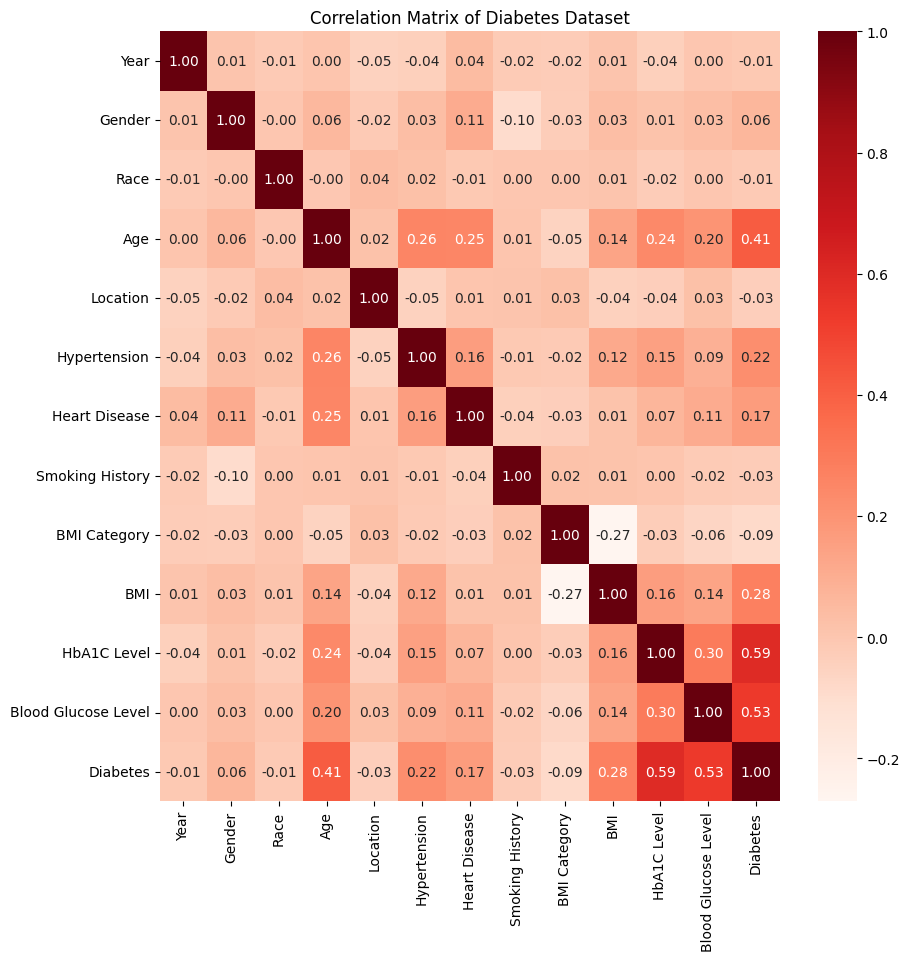

In [20]:
plt.figure(figsize=(10, 10))
sns.heatmap(corr_mat, annot = True, cmap = "Reds", fmt='.2f')
plt.title("Correlation Matrix of Diabetes Dataset")
plt.show()

# Drill-down Analysis

<ipython-input-21-51dbdadd4945>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  c.set_xticklabels(["Non-Diabetic", "Diabetic"])


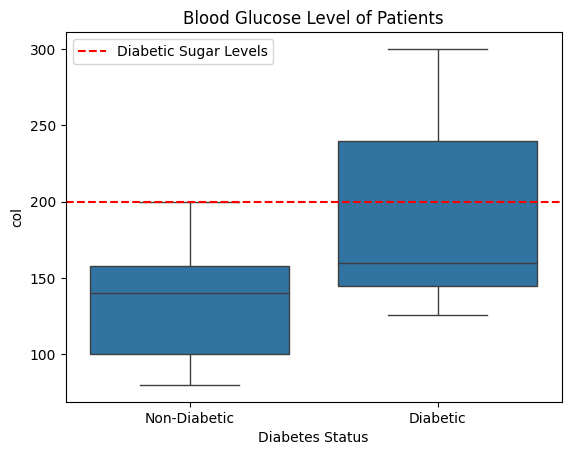

<ipython-input-21-51dbdadd4945>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  c.set_xticklabels(["Non-Diabetic", "Diabetic"])


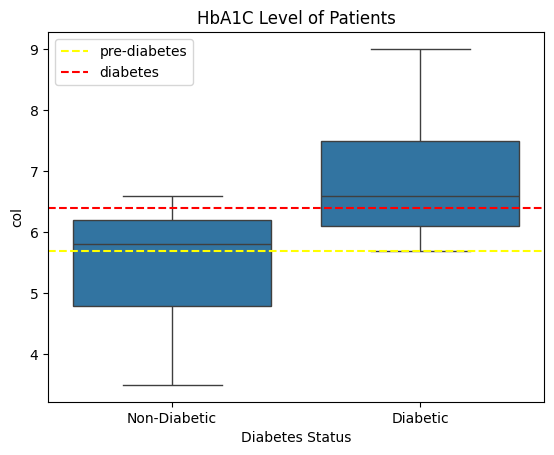

In [21]:
columns =  ["Blood Glucose Level", "HbA1C Level"]

for col in columns:

    c = sns.boxplot(data = df2, x = "Diabetes", y = col)
    c.set_title(f"{col} of Patients")
    c.set_xlabel("Diabetes Status")
    c.set_ylabel(f"col")
    c.set_xticklabels(["Non-Diabetic", "Diabetic"])
    if col == "Blood Glucose Level":
        c.axhline(y = 200, c = "red", ls = "--", label = "Diabetic Sugar Levels")
    else:
        c.axhline(y = 5.7, c = "yellow", ls = "--",label = "pre-diabetes")
        c.axhline(y = 6.4, c = "red", ls = "--",label = "diabetes")
    c.legend()
    plt.show()

In [22]:
columns =  ["Blood Glucose Level", "HbA1C Level"]

for col in columns:
    Nondiabetic = df2[df2["Diabetes"] == 0][col]
    Diabetic = df2[df2["Diabetes"] == 1][col]
    data = [Nondiabetic, Diabetic]
    for d in data:
        stats, pval = shapiro(d)
        if pval <= 0.05:
            print(f"The distribution of {col} is not normal.")
        else:
            print(f"The distribution of {col} is normal.")

The distribution of Blood Glucose Level is not normal.
The distribution of Blood Glucose Level is not normal.
The distribution of HbA1C Level is not normal.
The distribution of HbA1C Level is not normal.


In [23]:
columns =  ["Blood Glucose Level", "HbA1C Level"]

for col in columns:

    stat, pval = mannwhitneyu(
        df2[df2["Diabetes"] == 1][col],
        df2[df2["Diabetes"] == 0][col], alternative = "greater")
    if pval > 0.05:
        print(f"p-value = {pval}. The {col} of patients with diabetes are not higher than those with diabetes.")
    else:
        print(f"p-value = {pval}. The {col} of patients with diabetes are higher than those with diabetes.")

p-value = 1.5757998716105479e-105. The Blood Glucose Level of patients with diabetes are higher than those with diabetes.
p-value = 5.299309081512308e-150. The HbA1C Level of patients with diabetes are higher than those with diabetes.


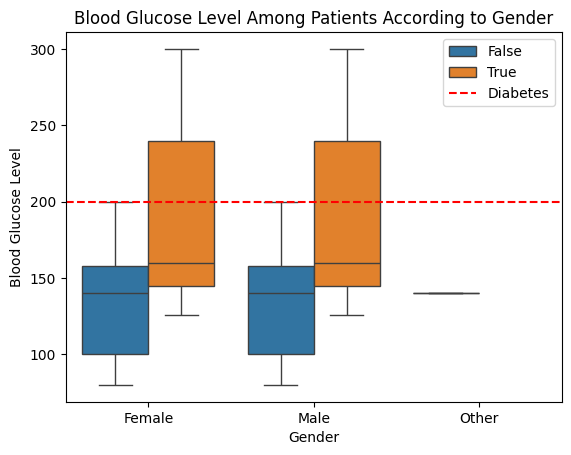

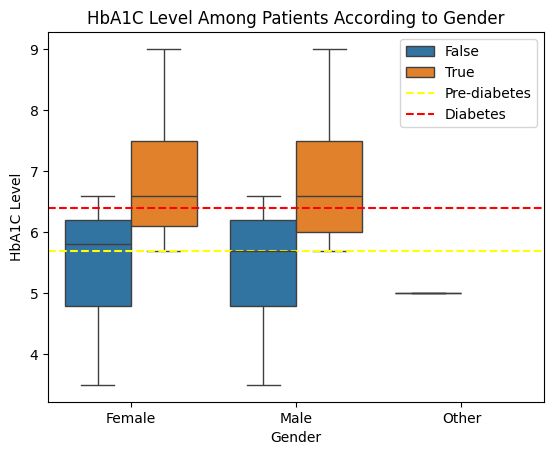

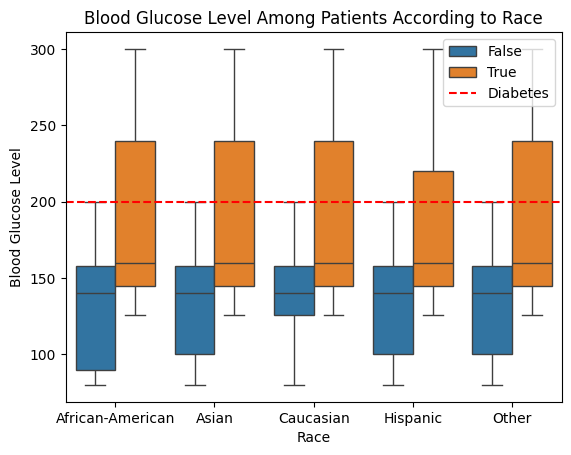

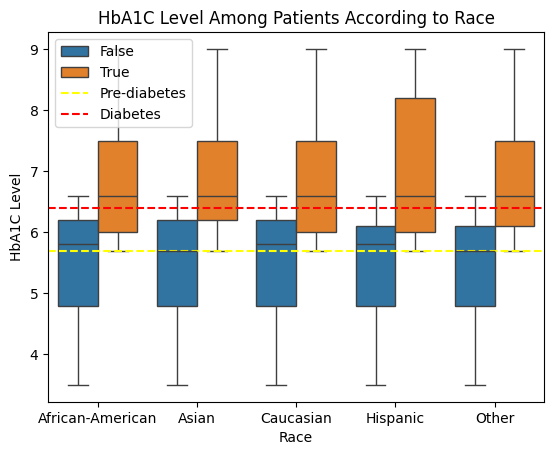

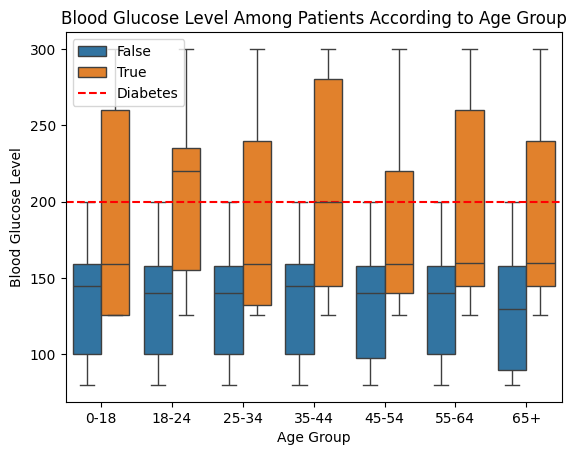

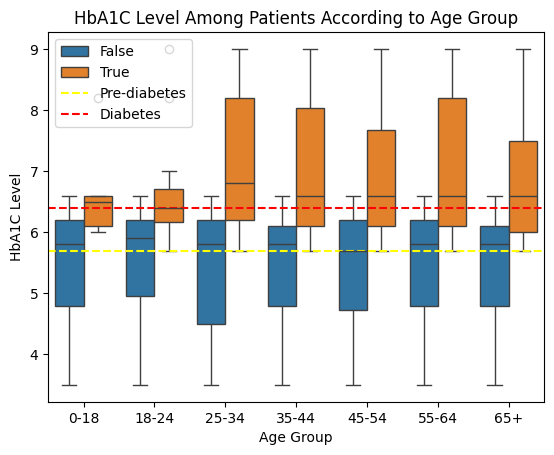

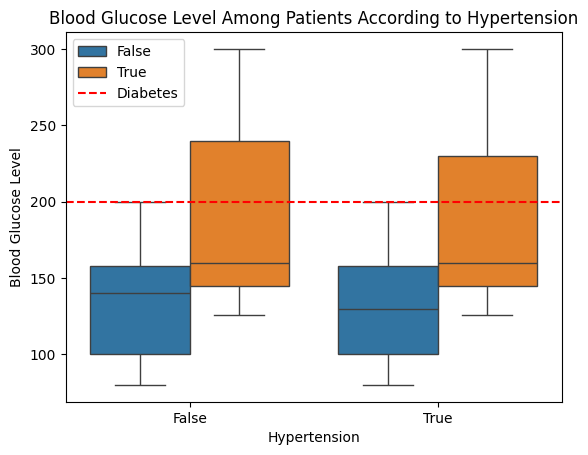

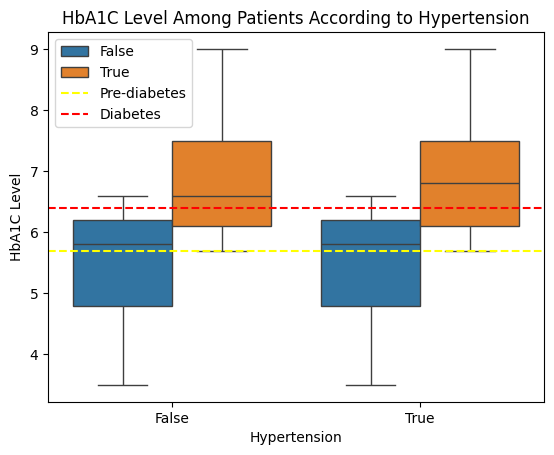

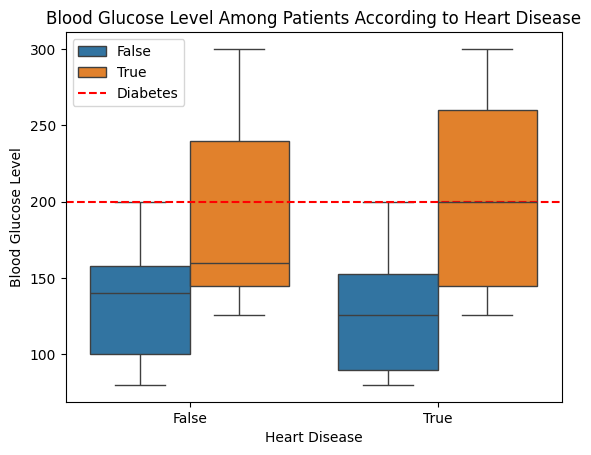

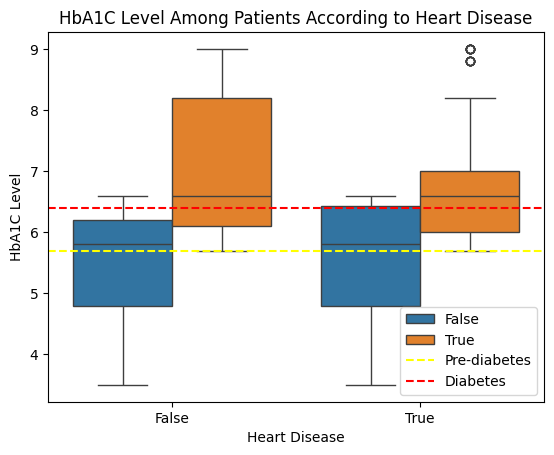

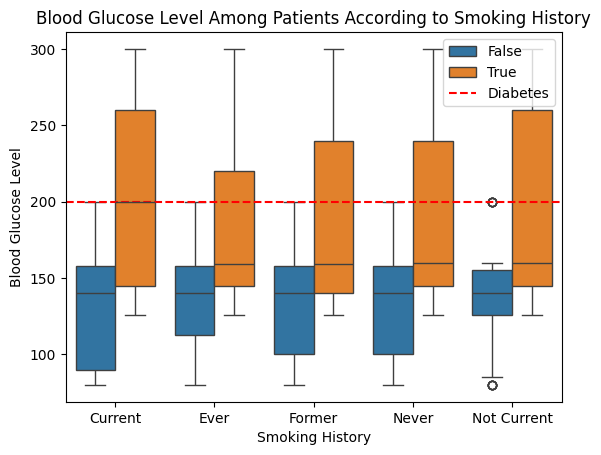

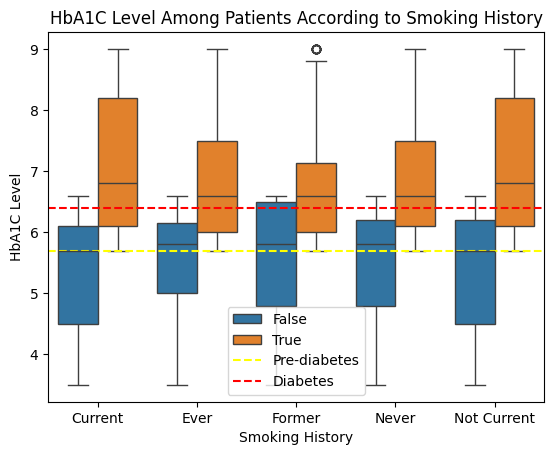

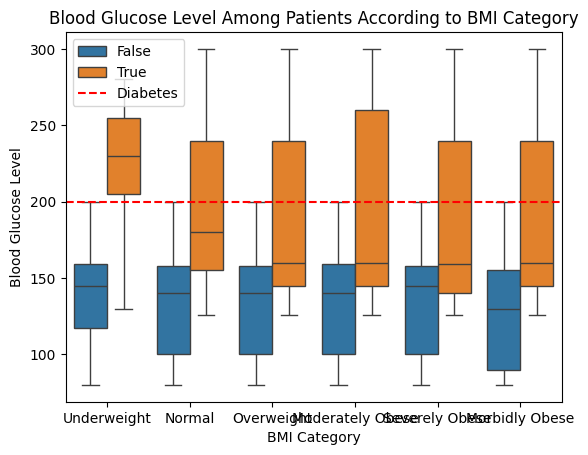

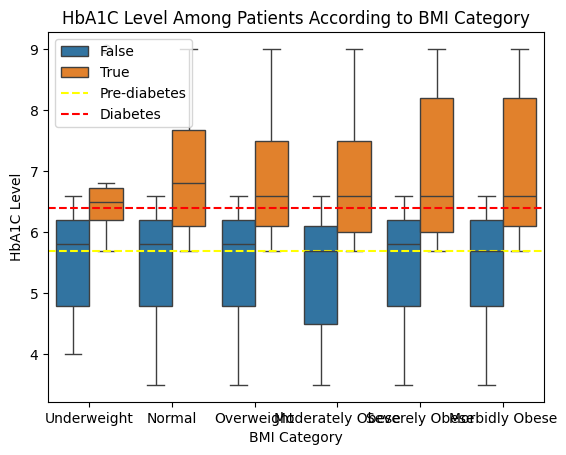

In [24]:
targets = ["Blood Glucose Level", "HbA1C Level"]
cat_columns.remove("Location")

for col in cat_columns:

    for target in targets:
        h = sns.boxplot(data = df2, x = col, y = target, hue = "Diabetes")
        h.set_title(f"{target} Among Patients According to {col}")
        h.set_xlabel(f"{col}")
        h.set_ylabel(f"{target}")

        if target == "Blood Glucose Level":
            h.axhline(y = 200, c = "red", ls = "--",label = "Diabetes")

        else:
            h.axhline(y = 5.7, c = "yellow", ls = "--",label = "Pre-diabetes")
            h.axhline(y = 6.4, c = "red", ls = "--",label = "Diabetes")

        h.legend()
        plt.show()

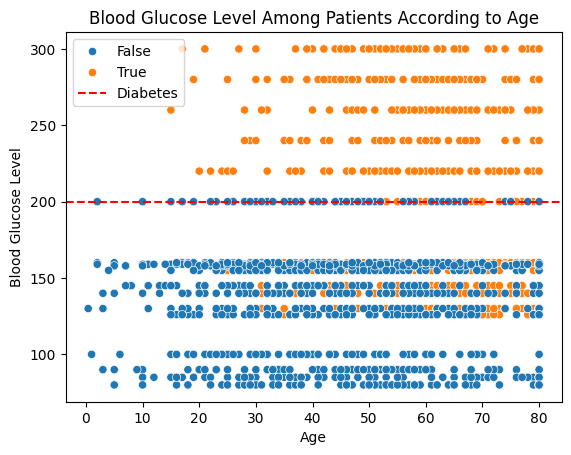

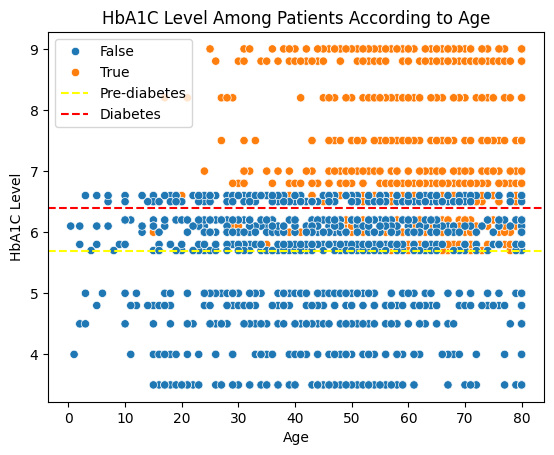

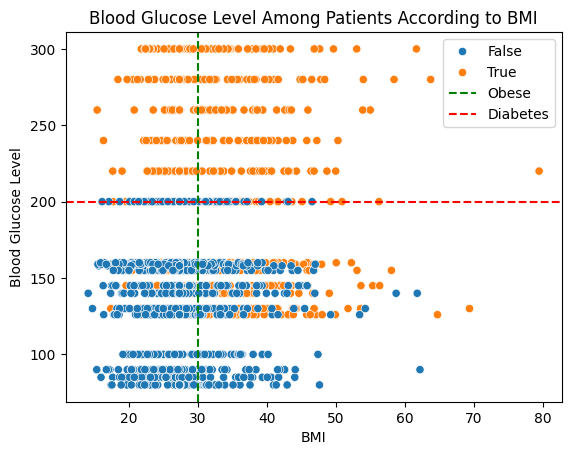

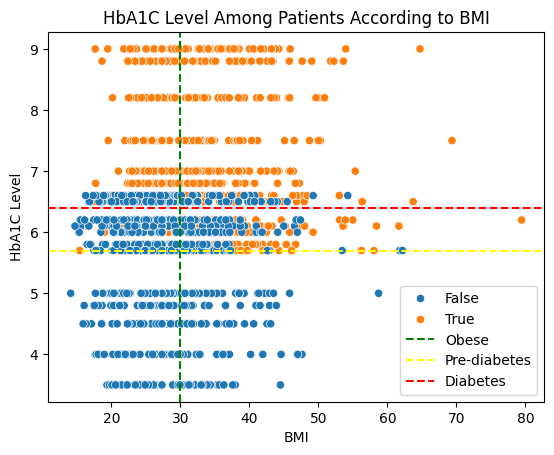

In [25]:
columns = ["Age", "BMI"]
targets = ["Blood Glucose Level", "HbA1C Level"]

for col in columns:

    for target in targets:

        h = sns.scatterplot(data = df2, x = col, y = target, hue = "Diabetes")
        h.set_title(f"{target} Among Patients According to {col}")

        if col == "BMI":
            h.axvline(x = 30, c = "green", ls = "--",label = "Obese")

        h.set_xlabel(f"{col}")
        h.set_ylabel(f"{target}")

        if target == "Blood Glucose Level":
            h.axhline(y = 200, c = "red", ls = "--",label = "Diabetes")

        else:
            h.axhline(y = 5.7, c = "yellow", ls = "--",label = "Pre-diabetes")
            h.axhline(y = 6.4, c = "red", ls = "--",label = "Diabetes")

        h.legend()
        plt.show()

# Statistical Tests for Relationship/Independence

In [26]:
cat_columns.append("Location")

for col in cat_columns:
    contingency_table  = pd.crosstab(df2[col], df2["Diabetes"])
    chi_square, p, dof, expected = chi2_contingency(contingency_table)
    critical_value = chi2.ppf(1 - 0.05, dof)

    if chi_square <= critical_value:
        print(f"There is no relationship between {col} and diabetes.")
        cat_columns.remove(col)

    else:
        print(f"There is a relationship between {col} and diabetes.")

There is a relationship between Gender and diabetes.
There is no relationship between Race and diabetes.
There is a relationship between Hypertension and diabetes.
There is a relationship between Heart Disease and diabetes.
There is a relationship between Smoking History and diabetes.
There is a relationship between BMI Category and diabetes.
There is no relationship between Location and diabetes.


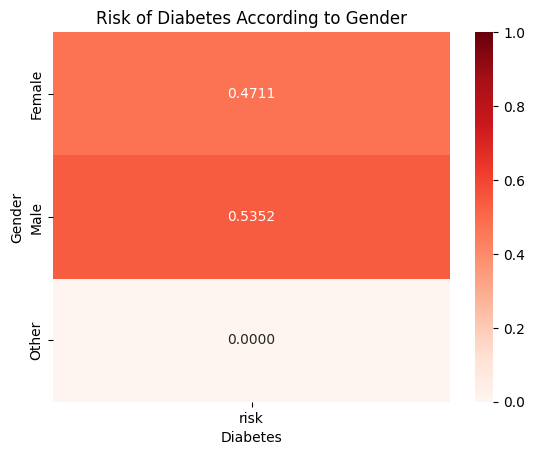

Male: 2.27 times more likely to develop diabetes.


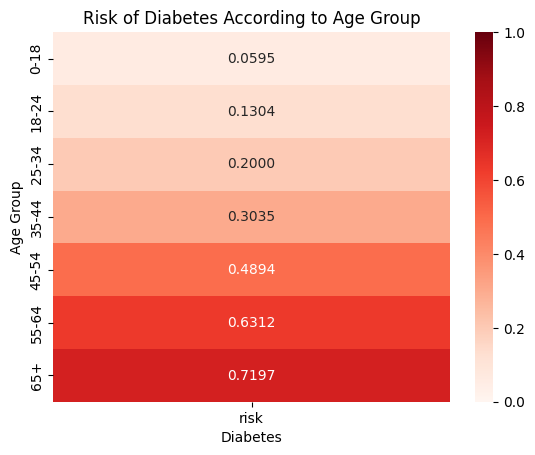

Ages 65+: 2.38 times more likely to develop diabetes.


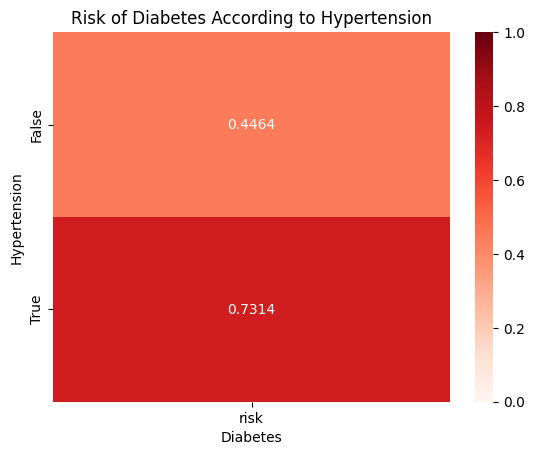

People with Hypertension: 1.64 times more likely to develop diabetes.


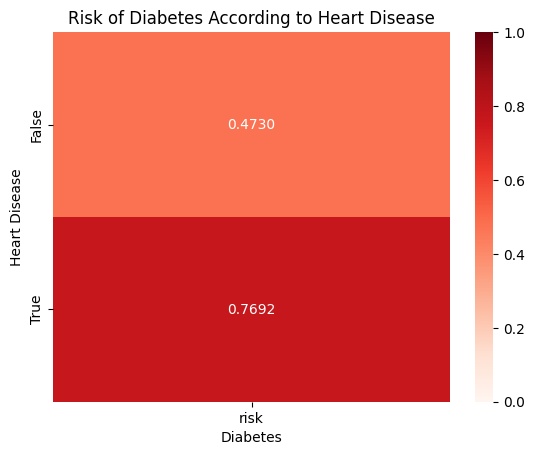

People with Heart Disease: 1.63 times more likely to develop diabetes.


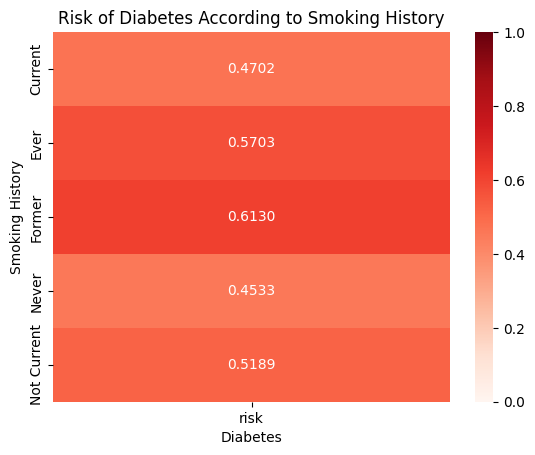

Former smokers: 1.22 times more likely to develop diabetes.


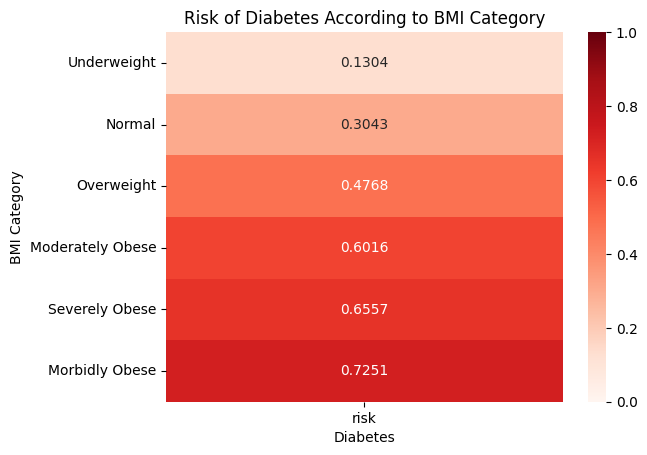

Morbidly Obese people: 1.67 times more likely to develop diabetes.


In [27]:
for col in cat_columns:

    contingency_table  = pd.crosstab(df2[col], df2["Diabetes"])
    contingency_table["total"] = contingency_table[False] + contingency_table[True]
    contingency_table["risk"] = contingency_table[True] / contingency_table["total"]
    risk_A_label = contingency_table["risk"].idxmax()
    risk_A = contingency_table.loc[risk_A_label, "risk"]
    risk_B = contingency_table.loc[contingency_table.index != risk_A_label, "risk"].mean()
    rr = round(risk_A/risk_B, 2)

    sns.heatmap(contingency_table.drop(columns = [True, False, "total"]), vmin = 0, vmax = 1, annot = True, cmap = "Reds", fmt = ".4f")
    plt.title(f"Risk of Diabetes According to {col}")
    plt.show()

    if col == "Age Group":
        print(f"Ages {risk_A_label}: {rr} times more likely to develop diabetes.")

    elif col in ["Hypertension", "Heart Disease"]:
        if risk_A_label == True:
            print(f"People with {col}: {rr} times more likely to develop diabetes.")
        else:
            print(f"People without {col}: {rr} times more likely to develop diabetes.")

    elif col == "Smoking History":
        print(f"{risk_A_label} smokers: {rr} times more likely to develop diabetes.")

    elif col == "BMI Category":
        print(f"{risk_A_label} people: {rr} times more likely to develop diabetes.")

    else:
        print(f"{risk_A_label}: {rr} times more likely to develop diabetes.")

# Prediction Model

## Data Preprocessing

In [28]:
X = df_encoded.drop(columns = ["Year", "Diabetes", "BMI Category"])
y = df_encoded["Diabetes"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
scaler_X = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

## Logistic Regression

In [29]:
logit = LogisticRegression()
logit.fit(X_train_scaled, y_train)
y_logit = logit.predict(X_test_scaled)
acc_logit = accuracy_score(y_logit, y_test)
class_rep_logit = classification_report(y_logit, y_test)
print("accuracy: ", acc_logit)
print(class_rep_logit)

accuracy:  0.8775
              precision    recall  f1-score   support

       False       0.89      0.87      0.88       206
        True       0.86      0.89      0.88       194

    accuracy                           0.88       400
   macro avg       0.88      0.88      0.88       400
weighted avg       0.88      0.88      0.88       400



## Decision Tree

In [30]:
tree = DecisionTreeClassifier(random_state = 42)
tree.fit(X_train_scaled, y_train)
y_tree = tree.predict(X_test_scaled)
acc_tree = accuracy_score(y_tree, y_test)
class_rep_tree = classification_report(y_tree, y_test)
print("accuracy: ", acc_tree)
print(class_rep_tree)

accuracy:  0.84
              precision    recall  f1-score   support

       False       0.84      0.84      0.84       199
        True       0.84      0.84      0.84       201

    accuracy                           0.84       400
   macro avg       0.84      0.84      0.84       400
weighted avg       0.84      0.84      0.84       400



## Random Forest

In [31]:
rf = RandomForestClassifier(random_state = 42)
rf.fit(X_train_scaled, y_train)
y_rf = rf.predict(X_test_scaled)
acc_rf = accuracy_score(y_rf, y_test)
class_rep_rf = classification_report(y_rf, y_test)
print("accuracy: ", acc_rf)
print(class_rep_rf)

accuracy:  0.9025
              precision    recall  f1-score   support

       False       0.92      0.89      0.90       208
        True       0.88      0.92      0.90       192

    accuracy                           0.90       400
   macro avg       0.90      0.90      0.90       400
weighted avg       0.90      0.90      0.90       400

